# SIRD model playground

Given the following equations of the SIRD model

\begin{align*}
\frac{dS}{dt} &= -\lambda \cdot S \cdot I \\
\frac{dI}{dt} &= \lambda \cdot S \cdot I - (\gamma \cdot I) - (\mu \cdot I) \\
\frac{dR}{dt} &= \gamma \cdot I \\
\frac{dD}{dt} &= \mu \cdot I
\end{align*}

Given the initial conditions: *population, cases, deaths, recovered* and *Basic reproductive rate (R0), Mortality rate ratio (M), Average infectios period (P)* it is possible to compute the correspondent ODEs and then obtain the *S, I, R, D* params

In [1]:
from sird_base_model import SIRD

In [2]:
# Initial params
initial_conditions = {
    'population': 60000000,
    'cases': 1577,
    'deaths': 34,
    'recovered': 83
}

# R0 = 1.5 # Basic reproduction number
# M = 0.3 # Mortality rate
# P = 5.1 # Period of infection
beta = 0.7
gamma = 0.2
delta = 0.1

In [3]:
model = SIRD(beta=beta, gamma=gamma, delta=delta)

For a population of 60000000 people, after 70 days there were:
29.0% total deaths, or 17370076 people.
57.9% total recovered, or 34740167 people.
At the virus' maximum 20.9% people were simultaneously infected, or 12563310 people.
After 70 days the virus was present in less than 4171 individuals.



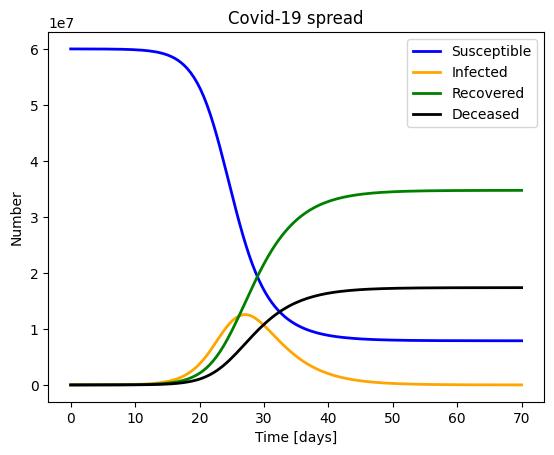

In [4]:
days = 70
model.solve(initial_conditions, days)
model.plot()
print()

In [5]:
model.soln

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.036e-01 ...  6.950e+01  7.000e+01]
        y: [[ 1.000e+00  1.000e+00 ...  1.314e-01  1.314e-01]
            [ 2.628e-05  3.215e-05 ...  7.720e-05  6.952e-05]
            [ 1.383e-06  4.317e-06 ...  5.790e-01  5.790e-01]
            [ 5.667e-07  2.033e-06 ...  2.895e-01  2.895e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 110
     njev: 0
      nlu: 0

In [6]:
# Parameters after a simulation
params = model.get_params()
print(params)

{'S': 0.1314264259184329, 'I': 6.951881045157061e-05, 'R': 0.5790027868474104, 'D': 0.2895012684237052, 'Sum params:': 1.0}
